### This notebook shows some lower-level functionality in `flopy` for working with shapefiles
including:
* `recarray2shp` convience function for writing a numpy record array to a shapefile
* `shp2recarray` convience function for quickly reading a shapefile into a numpy recarray
* `utils.geometry` classes for writing shapefiles of model input/output. For example, quickly writing a shapefile of model cells with errors identified by the checker
* demonstration of how the `epsgRef` class works for retrieving projection file information (WKT text) from spatialreference.org, and caching that information locally for when an internet connection isn't available
* how to reset `epsgRef` if it becomes corrupted
* examples of how the `Point` and `LineString` classes can be used to quickly plot pathlines and endpoints from MODPATH (these are also used by the `PathlineFile` and `EndpointFile` classes to write shapefiles of this output)

In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
from flopy.utils.geometry import Polygon, LineString, Point
from flopy.export.shapefile_utils import recarray2shp, shp2recarray
from flopy.utils.modpathfile import PathlineFile, EndpointFile
from flopy.utils import geometry
from flopy.utils.reference import epsgRef
ep = epsgRef()
ep.reset()

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

Resetting /Users/jdhughes/Library/Application Support/flopy/epsgref.json
3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.19.2
matplotlib version: 3.3.0
flopy version: 3.3.2


### write a numpy record array to a shapefile
in this case, we want to visualize output from the checker  
first make a toy model

In [2]:
m = flopy.modflow.Modflow('toy_model', model_ws='data')
botm = np.zeros((2, 10, 10))
botm[0, :, :] = 1.5
botm[1, 5, 5] = 4 # negative layer thickness!
botm[1, 6, 6] = 4
dis = flopy.modflow.ModflowDis(nrow=10, ncol=10, 
                               nlay=2, delr=100, delc=100,
                               top=3, botm=botm, model=m)

In [3]:
grid = m.modelgrid
grid.set_coord_info(xoff=600000, yoff=5170000, proj4='EPSG:26715', angrot=45)

In [4]:
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  2 Errors:
    2 instances of zero or negative thickness

  Checks that passed:
    thin cells (less than checker threshold of 1.0)
    nan values in top array
    nan values in bottom array



rec.array([('Error', 'DIS', 1, 5, 5, -2.5, 'zero or negative thickness'),
           ('Error', 'DIS', 1, 6, 6, -2.5, 'zero or negative thickness')],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('value', '<f8'), ('desc', 'O')])

### make geometry objects for the cells with errors  
*  geometry objects allow the shapefile writer to be simpler and agnostic about the kind of geometry

In [5]:
get_vertices = m.modelgrid.get_cell_vertices # function to get the referenced vertices for a model cell
geoms = [Polygon(get_vertices(i, j)) for i, j in chk.summary_array[['i', 'j']]]

In [6]:
geoms[0].type

'Polygon'

In [7]:
geoms[0].exterior

((600000.0, 5170707.106781187),
 (600070.7106781186, 5170777.817459305),
 (600141.4213562373, 5170707.106781187),
 (600070.7106781186, 5170636.396103068))

In [8]:
geoms[0].bounds

(600000.0, 5170636.396103068, 600141.4213562373, 5170777.817459305)

<AxesSubplot:>

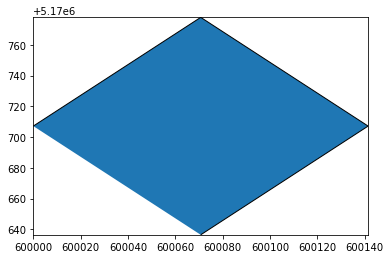

In [9]:
geoms[0].plot() # this feature requires descartes

### write the shapefile  
* the projection (.prj) file can be written using an epsg code  
* or copied from an existing .prj file

In [10]:
recarray2shp(chk.summary_array, geoms, 'data/test.shp', epsg=26715)

wrote data/test.shp


In [11]:
shutil.copy('data/test.prj', 'data/26715.prj')
recarray2shp(chk.summary_array, geoms, 'data/test.shp', prj='data/26715.prj')

wrote data/test.shp


### read it back in  
* flopy geometry objects representing the shapes are stored in the 'geometry' field

In [12]:
ra = shp2recarray('data/test.shp')
ra

rec.array([('Error', 'DIS', 1, 5, 5, -2.5, 'zero or negative thickness', <flopy.utils.geometry.Polygon object at 0x12a23f750>),
           ('Error', 'DIS', 1, 6, 6, -2.5, 'zero or negative thickness', <flopy.utils.geometry.Polygon object at 0x12a23f7d0>)],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('value', '<f8'), ('desc', 'O'), ('geometry', 'O')])

<AxesSubplot:>

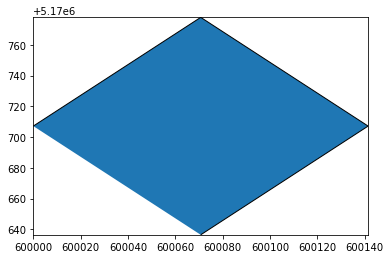

In [13]:
ra.geometry[0].plot()

### How the epsg feature works  
* requires an internet connection the first time to get the prj text from [spatialreference.org](https://spatialreference.org/) using ```requests```  
* if it doesn't exist, ```epsgref.json``` is created in the user's data directory
* the prj text is then stashed in this JSON file hashed by the EPSG numeric code

In [14]:
from flopy.utils.reference import epsgRef
ep = epsgRef()
prj = ep.to_dict()
prj

OrderedDict([(26715,
              'PROJCS["NAD_1927_UTM_Zone_15N",GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",SPHEROID["Clarke_1866",6378206.4,294.9786982138982]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]')])

In [15]:
from flopy.utils.reference import getprj, epsgRef

In [16]:
getprj(4326)

'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'

In [17]:
prj = ep.to_dict()
for k, v in prj.items():
    print('{}:\n{}\n'.format(k, v))

26715:
PROJCS["NAD_1927_UTM_Zone_15N",GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",SPHEROID["Clarke_1866",6378206.4,294.9786982138982]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]

4326:
GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]



### working with the ```flopy.utils.reference.epsgRef``` handler

In [18]:
ep = epsgRef()

In [19]:
ep.add(9999, 'junk')

In [20]:
epsgRef.show()

26715:
PROJCS["NAD_1927_UTM_Zone_15N",GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",SPHEROID["Clarke_1866",6378206.4,294.9786982138982]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]

4326:
GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]

9999:
junk



#### remove an entry

In [21]:
ep.remove(9999)
epsgRef.show()

26715:
PROJCS["NAD_1927_UTM_Zone_15N",GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",SPHEROID["Clarke_1866",6378206.4,294.9786982138982]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]

4326:
GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]



#### start over with a new file

In [22]:
ep.reset()

Resetting /Users/jdhughes/Library/Application Support/flopy/epsgref.json


In [23]:
prj = ep.to_dict()
prj

OrderedDict()

In [24]:
len(prj.keys())

0

## Other geometry types

### Linestring  
* create geometry objects for pathlines from a MODPATH simulation
* plot the paths using the built in plotting method

In [25]:
pthfile = PathlineFile('../data/mp6/EXAMPLE-3.pathline')
pthdata = pthfile._data.view(np.recarray)

In [26]:
length_mult = 1. # multiplier to convert coordinates from model to real world
rot = 0 # grid rotation

particles = np.unique(pthdata.particleid)
geoms = []
for pid in particles:
    ra = pthdata[pthdata.particleid == pid]

    x, y = geometry.rotate(ra.x * length_mult,
                           ra.y * length_mult,
                           grid.xoffset,
                           grid.yoffset,
                           rot)
    z = ra.z
    geoms.append(LineString(list(zip(x, y, z))))

In [27]:
geoms[0]

<AxesSubplot:>

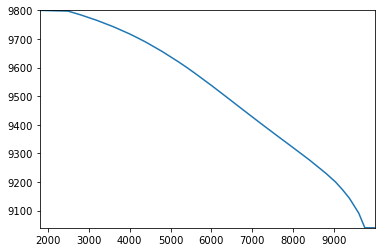

In [28]:
geoms[0].plot()

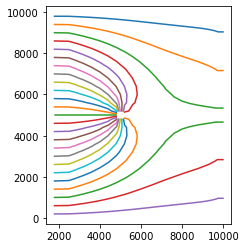

In [29]:
fig, ax = plt.subplots()
for g in geoms:
    g.plot(ax=ax)
ax.autoscale()
ax.set_aspect(1)

## Points

In [30]:
eptfile = EndpointFile('../data/mp6/EXAMPLE-3.endpoint')
eptdata = eptfile.get_alldata()

In [31]:
x, y = geometry.rotate(eptdata['x0'] * length_mult,
                       eptdata['y0'] * length_mult,
                       grid.xoffset,
                       grid.yoffset,
                       rot)
z = eptdata['z0']

geoms = [Point(x[i], y[i], z[i]) for i in range(len(eptdata))]

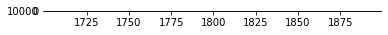

In [32]:
fig, ax = plt.subplots()
for g in geoms:
    g.plot(ax=ax)
ax.autoscale()
ax.set_aspect(2e-6)